<a href="https://colab.research.google.com/github/AlirezaPNouri/Storytelling/blob/main/TF_IDF_Keyword_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, TF-IDF technique has been used to extract keywords from a text

In [34]:
import pickle
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [35]:
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [46]:
df = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/df.p', 'rb'))
story = pickle.load(open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'rb'))

In [7]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [5]:
def pre_process(text):
    # lowercase
    text = text.lower()
    # remove tags
    text = re.sub("", "", text)
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    return text

In [31]:
def stopword_remover(str_, stopwords_):
  words = word_tokenize(str_)
  ps = PorterStemmer()
  temp_list = list()
  for ele in words:
    if ele not in stopwords_:
      temp_list.append(ps.stem(ele))
  return ' '.join(temp_list)



In [36]:
print(stopword_remover(pre_process(special_char_remover(' Alireza is a good \ boy')), stopwords))

alireza good boy


In [37]:
data_content = dict()
for index, row in df.iterrows():
  data_content[row['id']] = stopword_remover(pre_process(special_char_remover(row['content'])), stopwords)


In [38]:
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)

In [39]:
word_count_vector = cv.fit_transform(data_content.values())

In [40]:
list(cv.vocabulary_.keys())[:10]

['object',
 'identifi',
 'percept',
 'physician',
 'expertis',
 'nurs',
 'home',
 'care',
 'valu',
 'primarili']

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [42]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [45]:

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names_out()
top_keywords = dict()
for ind, doc in data_content.items():
  # get the document that we want to extract keywords from
  # doc=data_content[51167]
  #generate tf-idf for the given document
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
  #sort the tf-idf vectors by descending order of scores
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  #extract only the top n; n here is 10
  keywords=extract_topn_from_vector(feature_names,sorted_items,100)
  # now print the results
  # print("\n=====Doc=====")
  # print(doc)
  # print("\n===Keywords===")
  temp_list = list()
  for k in keywords:
    temp_list.append(k)
    # print(k,keywords[k])
  top_keywords[ind] = temp_list

In [51]:
def jaccard_similarity(text1, text2):
  set_text1 = set(text1)
  set_text2 = set(text2)

  return len(set_text1.intersection(set_text2)) / len(set_text1.union(set_text2))

In [64]:
sampl = story[0.25][1]
keyword_story = dict()
for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
  keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1], top_keywords[doc_2])




In [66]:
total_dict = dict()

for total in range(len(story[0.25])):
  sampl = story[0.25][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1], top_keywords[doc_2])
  total_dict[total] = keyword_story



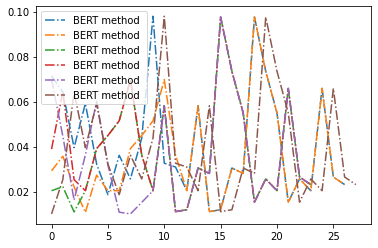

In [69]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
y = list(total_dict[0].values())
x = [x for x in range(len(keyword_story.keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = list(total_dict[1].values())
x = [x for x in range(len(total_dict[1].keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = list(total_dict[2].values())
x = [x for x in range(len(total_dict[2].keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = list(total_dict[3].values())
x = [x for x in range(len(total_dict[3].keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = list(total_dict[4].values())
x = [x for x in range(len(total_dict[4].keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = list(total_dict[5].values())
x = [x for x in range(len(total_dict[5].keys()))]
plt.plot(x, y, label = "BERT method ", linestyle="-." )

plt.legend()
plt.show()